<a href="https://colab.research.google.com/github/DiaaEssam/Convolution_model_Step_by_Step/blob/main/ANN_from_scratch_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import mnist
import tensorflow as tf
tf.test.gpu_device_name()
np.seterr(over='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

# Loading MNIST Dataset

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


# Applying One Hot Encodeing for labels

In [3]:
"""num_classes=len(np.unique(y_train))
y_train=np.array([np.insert(np.zeros(num_classes-1),i,1) for i in y_train]).astype(int) another way implemented by me"""

from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
y_train=enc.fit_transform(y_train.reshape(y_train.shape[0],1)).toarray().astype(int)
y_test=enc.transform(y_test.reshape(y_test.shape[0],1)).toarray().astype(int)

print(y_train.shape)
print(y_train[0])
print(y_test.shape)
print(y_test[0])

(60000, 10)
[0 0 0 0 0 1 0 0 0 0]
(10000, 10)
[0 0 0 0 0 0 0 1 0 0]


# Visualizing some of The Data

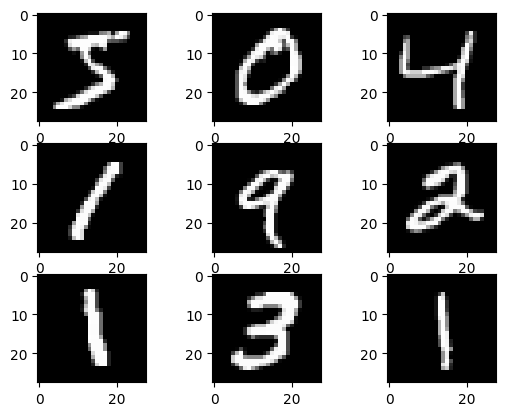

In [4]:
for i in range(9):  
  plt.subplot(330 + 1 + i)
  plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
plt.show()

# Transforming The Dimensions

In [5]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train=X_train.reshape(X_train.shape[0],-1)
X_test=X_test.reshape(X_test.shape[0],-1)
print(X_train)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [6]:
print('X_train: ' + str(X_train.shape))
print('Y_train: ' + str(y_train.shape))
print('X_test:  '  + str(X_test.shape))
print('Y_test:  '  + str(y_test.shape))

X_train: (60000, 784)
Y_train: (60000, 10)
X_test:  (10000, 784)
Y_test:  (10000, 10)


# Standardizing The Data

In [7]:
"""
Standardizing both the training set and test set using the mean and standard deviation of the training set,
This is because it ensures that the test set is processed in the same way as the training set,
and that the model's performance is evaluated on data that it has not seen before, without any information from the test set leaking into the training set.
see the following link: https://stats.stackexchange.com/questions/202287/why-standardization-of-the-testing-set-has-to-be-performed-with-the-mean-and-sd
"""
def standardize(X,X_train):
  return (X-np.mean(X_train,axis=0))/(np.std(X_train,axis=0) + 10e-16) # we need epsilon for feature (pixel) that has zero variance

In [8]:
X_train=standardize(X_train,X_train)
X_test=standardize(X_test,X_test)
#X_test=standardize(X_test,X_train) # correct way

# Shuffle Function

In [9]:
def Shuffle(X,y):
  # Storing indeces of data
  indices = np.arange(X.shape[0])
  # Shuffling the indeces
  np.random.shuffle(indices)
  # update the data and target with the new shuffled indeces
  X = X[indices]
  y = y[indices]
  return X,y

In [10]:
X_train,y_train=Shuffle(X_train,y_train)

# Accuracy Function

In [11]:
def Accuracy(y_pred,y_test):
    # argmax returns the index of the maximum element in a numpy array 
    Acc=np.mean(np.argmax(y_test, axis=1) == np.argmax(y_pred, axis=1),axis=0) * 100
    return round(Acc,1)

# Error Function

In [12]:
def Error(y_pred,y_test):
  return  (1/(2*y_test.shape[0])) * np.sum((y_pred-y_test)**2)

# Sigmoid Function

In [13]:
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

# Softmax Function

In [14]:
def softmax(Z):
  # Divides the exponent of Z on the sum of each row vector
  Z=np.exp(Z)/np.sum(np.exp(Z),axis=1,keepdims=True)
  return Z

# Layer_Size Function

In [15]:
def layer_sizes(X,y,size_of_layers):
    # Inserts the size of the input layer at the start of the array
    size_of_layers.insert(0,X.shape[1])
    return size_of_layers

In [16]:
L_sizes=layer_sizes(X_train,y_train,[20,10])

# Printing shapes

In [17]:
def Print_shapes(container,param):
  if param:
    # Prints each W and each b between the layers
    print('L',['layer '+str(i) for i in range(len(container["W"])+1)])
    print('W',[container['W'][i].shape for i in range(len(container["W"]))])
    print('b',[container['b'][i].shape for i in range(len(container["W"]))])
  else:
    # Prints each dW and each db between the layers
    print('L',['layer '+str(i) for i in range(len(container["dW"])+1)])
    print('dW',[container['dW'][i].shape for i in range(len(container["dW"]))])
    print('db',[container['db'][i].shape for i in range(len(container["dW"]))])

#Initializing the model's parameters

In [18]:
def initialize_parameters(L_sizes):
    W=[]
    b=[]
    # Inialize W to be size of next layer by size of current layer, Inialize b to be size of next layer by 1
    for i in range(len(L_sizes)-1):
      W.append(np.random.randn(L_sizes[i+1],L_sizes[i]))
      b.append(np.zeros((L_sizes[i+1],1)))
    
    parameters = {
        'W':W,
        'b':b
    }

    Print_shapes(parameters,True)
    
    return parameters

# Forward propagation

In [19]:
def forward_propagation(X, parameters,Tanh=False):
    
    Z=[]
    A=[]
    for i in range(len(parameters["W"])):
                                                                  # if we are at the first layer then we use X, O.W. we use A[L-1]
      Z.append(np.dot(parameters["W"][i],X.T) + parameters["b"][i]) if i==0 else Z.append(np.dot(parameters["W"][i],A[i-1]) + parameters["b"][i])
      if Tanh:
        A.append(sigmoid(Z[i])) if i==len(parameters["W"])-1 else A.append(np.tanh(Z[i]))
      else:
        A.append(sigmoid(Z[i]))


    cache = {
        'Z':Z,
        'A':A
    }
    
    
    return cache

# Backward Propagation

In [20]:
def backward_propagation(parameters, cache, X, y,print_once,Tanh=False):

    dZ=[]
    dW=[]
    db=[]
    j=0

    # we will move backward so I reversed the direction of the iterator by giving (no. layer-1, -1 which will make the iterator stop at 0,-1 which is responsible for reversing the direction)
    for i in range(len(parameters["W"])-1,-1,-1):
    # if last layer then compute dL/dZ = A[L] - y
      if i==len(parameters["W"])-1:
        dZ.append(cache['A'][i].T-y)  
    # else compute dL/dZ[L] = W[L+1] * dL/dZ[L+1] * dA/dZ[L], where dA/dZ[L] = A[L] * (1 - A[L])
      else:
        if Tanh:                                                                      # we check here if we can use dot product properly or do we need to transpose one of the arrays so the dot product could work
          dZ.append(np.dot(parameters["W"][i+1].T,dZ[j-1].T) * (1 - cache["A"][i]**2)) if parameters["W"][i+1].T.shape[1]==dZ[j-1].T.shape[0] else dZ.append(np.dot(parameters["W"][i+1].T,dZ[j-1]) * (1 - cache["A"][i]**2))
        else:                                                                                       # we check here if we can use dot product properly or do we need to transpose one of the arrays so the dot product could work
          dZ.append(np.dot(parameters["W"][i+1].T,dZ[j-1].T) * (cache["A"][i] * (1 - cache["A"][i]))) if parameters["W"][i+1].T.shape[1]==dZ[j-1].T.shape[0] else dZ.append(np.dot(parameters["W"][i+1].T,dZ[j-1]) * (cache["A"][i] * (1 - cache["A"][i])))
    # if first layer then compute dL/dW[L] = dL/dZ[L] * X
      if i==0:
        dW.append(1/y.shape[0] * np.dot(dZ[j],X))   
    # else compute dL/dW[L] = dL/dZ[L] * A[L-1]
      else:                                                         # we check here if we can use dot product properly or do we need to transpose one of the arrays so the dot product could work
        dW.append(1/y.shape[0] * np.dot(dZ[j].T,cache['A'][i-1].T))  if dZ[j].T.shape[1]==cache['A'][i-1].T.shape[0] else  dW.append(1/y.shape[0] * np.dot(dZ[j],cache['A'][i-1].T))
                                                                    # we make sure that the size of db be the same as b not (60000,1)
      db.append(1/y.shape[0] * np.sum(dZ[j],axis=1,keepdims=True)) if np.sum(dZ[j],axis=1,keepdims=True).shape[0]!=X.shape[0] else db.append(1/y.shape[0] * np.sum(dZ[j].T,axis=1,keepdims=True))

      j+=1
    
    grads = {
        'dW':dW,
        'db':db
    }
        
    Print_shapes(grads,False) if print_once else ""
    
    return grads

# Update Parameters

In [21]:
def update_parameters(parameters, grads, learning_rate = 1.2):

    for i in range(len(parameters["W"])):
    # last value stored in dW and db are the gradients for the first W and b, that's why we are using parameters["W"])-1-i
      parameters["W"][i]=parameters["W"][i]-learning_rate * grads['dW'][len(parameters["W"])-1-i]
      parameters["b"][i]=parameters["b"][i]-learning_rate * grads['db'][len(parameters["W"])-1-i]
    
    return parameters

# Neural Network Using Sigmoid

In [22]:
def NN(X, y,num_of_layers,size_of_layers,epochs,LR,Tanh=False):
    L_sizes=layer_sizes(X,y,size_of_layers)
    parameters=initialize_parameters(L_sizes)
    
    print_once=True
    for i in range(epochs):
      # applying forward propagation
        cache=forward_propagation(X, parameters,Tanh)
      # computing Error/Cost
        cost=Error(cache['A'][-1].T,y)
      # Computing gradients
        grads=backward_propagation(parameters,cache,X,y,print_once,Tanh)
        print_once=False
      # Updating the parameters
        parameters=update_parameters(parameters,grads,learning_rate=LR)
        
        if i % 50 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters

# Test_model Function

In [23]:
# function to test on each model
def test_model(parameters,X_test,y_test):
    y_pred=np.zeros((X_test.shape[0],y_test.shape[1]))
    # calling forward propagation to make predictions
    cache=forward_propagation(X_test,parameters)
    # using softmax on y_pred
    y_pred=softmax(cache['A'][-1].T)
    return Accuracy(y_pred,y_test)

# 1- Build NN with only 2 layers => 1 hidden layer and 1 output layer

In [24]:
parameters=NN(X_train, y_train,2,[20,10],200,4.5)

L ['layer 0', 'layer 1', 'layer 2']
W [(20, 784), (10, 20)]
b [(20, 1), (10, 1)]
L ['layer 0', 'layer 1', 'layer 2']
dW [(10, 20), (20, 784)]
db [(10, 1), (20, 1)]
Cost after iteration 0: 1.668998
Cost after iteration 50: 0.198551
Cost after iteration 100: 0.150770
Cost after iteration 150: 0.127873


In [25]:
print(test_model(parameters,X_test,y_test))

85.8


## 2- Build NN with 3 layers=> 2 hidden layers Where no. of neurons in first layer < no. of neurons in second layer and 1 output layer

In [27]:
parameters=NN(X_train, y_train,3,[20,40,10],200,4.5)

L ['layer 0', 'layer 1', 'layer 2', 'layer 3']
W [(20, 784), (40, 20), (10, 40)]
b [(20, 1), (40, 1), (10, 1)]
L ['layer 0', 'layer 1', 'layer 2', 'layer 3']
dW [(10, 40), (40, 20), (20, 784)]
db [(10, 1), (40, 1), (20, 1)]
Cost after iteration 0: 2.795803
Cost after iteration 50: 0.284033
Cost after iteration 100: 0.166087
Cost after iteration 150: 0.128613


In [28]:
print(test_model(parameters,X_test,y_test))

84.8


## 3- Build NN with 3 layers=> 2 hidden layers Where no. of neurons in first layer > no. of neurons in second layer

In [29]:
parameters=NN(X_train, y_train,3,[30,15,10],200,4.5)

L ['layer 0', 'layer 1', 'layer 2', 'layer 3']
W [(30, 784), (15, 30), (10, 15)]
b [(30, 1), (15, 1), (10, 1)]
L ['layer 0', 'layer 1', 'layer 2', 'layer 3']
dW [(10, 15), (15, 30), (30, 784)]
db [(10, 1), (15, 1), (30, 1)]
Cost after iteration 0: 1.494489
Cost after iteration 50: 0.271608
Cost after iteration 100: 0.194203
Cost after iteration 150: 0.151534


In [30]:
print(test_model(parameters,X_test,y_test))

82.4


# 1- Build NN_Tanh with only 2 layers => 1 hidden layer and 1 output layer

In [31]:
parameters=NN(X_train, y_train,2,[20,10],200,8.5,Tanh=True)

L ['layer 0', 'layer 1', 'layer 2']
W [(20, 784), (10, 20)]
b [(20, 1), (10, 1)]
L ['layer 0', 'layer 1', 'layer 2']
dW [(10, 20), (20, 784)]
db [(10, 1), (20, 1)]
Cost after iteration 0: 2.088557
Cost after iteration 50: 0.151824
Cost after iteration 100: 0.119393
Cost after iteration 150: 0.105601


In [32]:
print(test_model(parameters,X_test,y_test))

71.6


## 2- Build NN_Tanh with 3 layers=> 2 hidden layers Where no. of neurons in first layer < no. of neurons in second layer and 1 output layer

In [33]:
parameters=NN(X_train, y_train,3,[20,40,10],200,8.5,Tanh=True)

L ['layer 0', 'layer 1', 'layer 2', 'layer 3']
W [(20, 784), (40, 20), (10, 40)]
b [(20, 1), (40, 1), (10, 1)]
L ['layer 0', 'layer 1', 'layer 2', 'layer 3']
dW [(10, 40), (40, 20), (20, 784)]
db [(10, 1), (40, 1), (20, 1)]
Cost after iteration 0: 2.117962
Cost after iteration 50: 0.162378
Cost after iteration 100: 0.120514
Cost after iteration 150: 0.105574


In [34]:
print(test_model(parameters,X_test,y_test))

41.1


## 3- Build NN_Tanh with 3 layers=> 2 hidden layers Where no. of neurons in first layer > no. of neurons in second layer

In [35]:
parameters=NN(X_train, y_train,3,[30,15,10],200,8.5,Tanh=True)

L ['layer 0', 'layer 1', 'layer 2', 'layer 3']
W [(30, 784), (15, 30), (10, 15)]
b [(30, 1), (15, 1), (10, 1)]
L ['layer 0', 'layer 1', 'layer 2', 'layer 3']
dW [(10, 15), (15, 30), (30, 784)]
db [(10, 1), (15, 1), (30, 1)]
Cost after iteration 0: 2.078380
Cost after iteration 50: 0.171115
Cost after iteration 100: 0.127410
Cost after iteration 150: 0.111718


In [36]:
print(test_model(parameters,X_test,y_test))

40.0
